## Extracting out tartu city bus schedule for the next couple months from the GTSF data base

Now to use this model to predict the future unvalidated tickets 

This code performs a variety of merges across the GTSF data base in order to reconstruct the bus schedule

In [1]:
import pandas as pd 

In [2]:
stops = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/stops.txt")
trips = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/trips.txt")
routes = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/routes.txt")
stop_times = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/stop_times.txt")
calendar = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/calendar.txt")
calendar_dates = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/calendar_dates.txt")

# this is the week I ultimately want to extract out
week = pd.date_range("2025-11-01", "2026-01-01")
week

calendar["start_date"] = pd.to_datetime(calendar["start_date"], format="%Y%m%d")
calendar["end_date"] = pd.to_datetime(calendar["end_date"], format="%Y%m%d")

# Create rows for each day between start_date and end_date
service_days = []

for _, row in calendar.iterrows():
    service_id = row["service_id"]
    days = pd.date_range(row["start_date"], row["end_date"])
    
    # Filter only days where this service runs
    for d in days:
        weekday = d.weekday()  # Monday=0
        if row[["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]].iloc[weekday] == 1:
            service_days.append({"service_id": service_id, "date": d})

service_days = pd.DataFrame(service_days)

In [3]:
service_days.head()

,service_id,date
0,21065,2019-09-02
1,21065,2019-09-03
2,21065,2019-09-04
3,21065,2019-09-05
4,21065,2019-09-06


In [4]:
calendar_dates["date"] = pd.to_datetime(calendar_dates["date"], format="%Y%m%d")

# Additions (exception_type = 1)
add = calendar_dates[calendar_dates["exception_type"] == 1][["service_id","date"]]

# Cancellations (exception_type = 2)
remove = calendar_dates[calendar_dates["exception_type"] == 2][["service_id","date"]]

# Apply:
service_days = pd.concat([service_days, add], ignore_index=True)
service_days = service_days.merge(remove, how="left", indicator=True, on=["service_id","date"])
service_days = service_days[service_days["_merge"] == "left_only"].drop(columns="_merge")


In [5]:
week_services = service_days[service_days["date"].isin(week)]


In [6]:
# Merge service_id → trips
valid_trips = trips.merge(week_services, on="service_id", how="inner")

# Merge trips → stop_times
df = stop_times.merge(valid_trips, on="trip_id", how="inner")

# Add routes + stop info
df = df.merge(routes, on="route_id", how="left") \
       .merge(stops, on="stop_id", how="left")


In [7]:
# Filtering for tartu only stops 
Unique_stop_codes = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe4/Unique_stops.csv")
valid_codes = Unique_stop_codes["Stop_ID"].unique()


df = df[df["stop_code"].isin(valid_codes)]

# Filtering for inner city busses only
Inner_buses = ['1', '10', '14', '15', '17', '18', '2', '20', '21', '22', '3', '4',
       '5', '6', '7', '8', '9', '16', '11', '12', '13', '19', '24', '26',
       '27', '28', '62', 'ATB', '69', '25', 'E1', '9A', '31R',
       '31']
df = df[df["route_short_name"].isin(Inner_buses)]


In [8]:
final = df[["date", "arrival_time", "stop_code", "route_short_name"]]
final = final.sort_values(["date", "arrival_time", "stop_code"])
final.rename(columns = {"stop_code" : "Stop_ID"}, inplace = True)

In [9]:
# Adding in day of week column
final["date"] = pd.to_datetime(final["date"])
final["Day_of_week"] = final["date"].dt.weekday
final.head()

,date,arrival_time,Stop_ID,route_short_name,Day_of_week
7869001,2025-11-01,04:20:00,7820249-1,21,5
7869010,2025-11-01,04:21:00,7820007-1,21,5
7869019,2025-11-01,04:22:00,7820239-1,21,5
7869028,2025-11-01,04:23:00,7820252-1,21,5
7869037,2025-11-01,04:25:00,7820291-1,21,5


# Exporting

In [8]:
final.to_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe1/Tartu_schedule.csv", index = False)

In [9]:
final.head()

,date,arrival_time,Stop_ID,route_short_name,Day_of_week
0,2025-11-01,04:20:00,7820249-1,21,5
1,2025-11-01,04:21:00,7820007-1,21,5
2,2025-11-01,04:22:00,7820239-1,21,5
3,2025-11-01,04:23:00,7820252-1,21,5
4,2025-11-01,04:25:00,7820291-1,21,5


In [13]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# importing so I dont have to run the above code again
final = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe1/Tartu_schedule.csv")

# Example: ensure 'date' column is datetime
final['date'] = pd.to_datetime(final['date'])

# Define the week you want
start_date = '2025-11-01'
end_date = '2025-11-07'  # inclusive

# Filter the DataFrame
week_df = final[(final['date'] >= start_date) & (final['date'] <= end_date)]

print(week_df)


             date arrival_time    Stop_ID route_short_name  Day_of_week
0      2025-11-01     04:20:00  7820249-1               21            5
1      2025-11-01     04:21:00  7820007-1               21            5
2      2025-11-01     04:22:00  7820239-1               21            5
3      2025-11-01     04:23:00  7820252-1               21            5
4      2025-11-01     04:25:00  7820291-1               21            5
...           ...          ...        ...              ...          ...
178653 2025-11-07     26:59:00  7820190-1               22            4
178654 2025-11-07     27:00:00  7820253-1               22            4
178655 2025-11-07     27:01:00  7820115-1               22            4
178656 2025-11-07     27:02:00  7820231-1               22            4
178657 2025-11-07     27:05:00  7820088-2               22            4

[178658 rows x 5 columns]


### Highlighting the **relative** sparsity of the "Ticket insepctions"

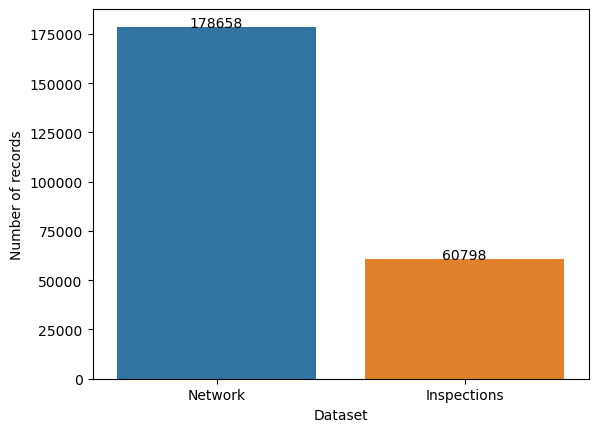

In [20]:
# This is the network for an entire week. Evrey entrance, exit of a bus across every bus stop
Network_size = len(week_df)

Inspections = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe2/Inspections.csv", parse_dates = ["Start_Dtime"])
Inspections_size = len(Inspections)


df = pd.DataFrame({
    "Dataset": ["Network", "Inspections"],
    "Size": [Network_size, Inspections_size]
})

# Plot
sns.barplot(data=df, x="Dataset", y="Size", hue = "Dataset")

# Optional: show the numbers on top of bars
for i, v in enumerate(df["Size"]):
    plt.text(i, v + 5, str(v), ha='center')  # adjust +5 for spacing

plt.ylabel("Number of records")
plt.show()


In [7]:
Network_size

1541159

In [8]:
Inspections_size

60798

In [12]:
df = pd.DataFrame({"Size" : [Network_size, Inspections_size]})

In [13]:
df

,Size
0,1541159
1,60798


In [ ]:
sns.barplot(data = df, x = "Size")